# Load the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a list of all the texts
texts = []
with open('sts2016-english-with-gs-v1.0/STS2016.input.answer-answer.txt', 'r') as f:
    for line in f:
        elements = line.strip().split('\t')
        texts.append(elements[0].replace('\n', ''))
        texts.append(elements[1])

In [3]:
for text in texts:
    print(text)

Tasting it is the only reliable way.
The way you have it is fine.
I think it probably depends on your money.
It depends on your country.
You need to read a lot to know what you like and what you don't.
You don't have to know.
Obviously, the best book for you depends a lot on what you are looking for.
The answer will depend of course on what you're looking for in a vacation.
I've had this same problem.
I had the same problem as you.
If you are not sure how to do it, don't do it at all.
Also, if you die, you don't have to repay, don't know if it helps.
It is more deciding what you should do and what you should get others to do.
What can you do and what should you do to grow more?
You need to add this to your resume because it is the only position you have had.
You may want it, but the process given to you is what you have to work within.
I remained under the banyan tree, exhausted by my daily ritual of dragooning the men every two hours. 
I remained under the banyan tree, exhausted by my

# Create Shingles for each text

In [4]:
shingles_per_text = []
k = 3
for text in texts:
    shingles_per_text.append(set([text[i:i + k] for i in range(len(text) - k + 1)]))

print(shingles_per_text[0])

{'e w', 'the', 'ay.', 'ng ', 'it ', 'Tas', ' th', ' on', 'iab', 't i', ' re', 's t', 'nly', 'rel', ' wa', 'abl', 'e o', 'he ', 'ble', 'ast', 'onl', 'ly ', 'way', ' it', 'y r', 'tin', 'sti', 'lia', 'eli', 'le ', ' is', 'is ', 'g i', 'ing'}


# Create Bit-Vector for each text (Matrix of Bit-Vectors [f. 51])

In [5]:
# create a set of all shingles
all_shingles_of_file = set()
for shingle_of_text in shingles_per_text:
    all_shingles_of_file.update(shingle_of_text)
print(all_shingles_of_file)

{'w.d', 'Onl', 'em:', 'ada', 'nyo', 'we ', 's/f', 'erg', 'onz', 'fun', 'k w', '0% ', ' ex', 'oye', 'st/', 'nad', 'beh', 'r e', 'mir', ':  ', 'Tas', 'r p', 'Int', 'be-', ' Sp', 'in,', 't i', 'de ', 'hUp', 'Lat', 'mpr', 'lie', 'ayc', 'rse', 'se.', 'use', 'sim', 'ks,', 'mmé', 'ork', 'g k', 't p', 'h h', 'ruc', 'gar', 'a g', 'ttp', 'AAA', 'ee ', 'dy ', 'Do ', 'fid', 'ew ', 'es,', ' ce', ' tu', 'dea', 'uet', 'ryt', 'of,', 'xim', 'k n', 'wei', 'bed', 'ff,', 'eba', 'hts', 'Foc', 'VE ', 'Pri', 'u a', "it'", 'ron', 'zat', 'sio', 'd s', 'lax', 'J14', 'dd/', 'a P', 'cul', 'kin', 'nar', 'kno', 'one', 'YOU', 'stl', 'oes', 'asi', 'on?', 'cs.', 'ut.', 'amo', 'x b', 'oof', 'n r', 'unl', 'lty', ' tr', 'egr', 'SE ', 'ewi', 'itl', 'ddr', 'te,', 'rat', 'aph', 'nci', 'fra', 'IRS', 'am,', 'fie', 'SA.', ' eq', 'sk/', 'mma', 'chU', 'rce', 'm u', 'de.', 'cov', 'spl', 'ble', 'idn', 'put', 'ex,', 'opr', 'it,', 'ict', 'ge ', 'sbe', 'Cur', 'g w', 'tep', 'ssi', 'ver', 'hab', '-so', 'f. ', 'da.', 'f s', 'y r', 'egy'

In [6]:
# create Bit-Vector for each text -> this will yield the matrix of the bit-vectors
bit_Matrix = []
for shingle_of_text in shingles_per_text:
    bit_vector_for_text = []
    
    for shingle_of_file in all_shingles_of_file:
        
        if shingle_of_file in shingle_of_text:
            bit_vector_for_text.append(1)
        else:
            bit_vector_for_text.append(0)
            
    bit_Matrix.append(bit_vector_for_text)

In [7]:
# nur um zz zeigen, dass es funktioniert
for vector in bit_Matrix:
    print(vector[0:16])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0

# Calculate MinHash-Signature for each text

# Create Hash-Functions (random permutations)

In [8]:
# generate n hash functions (random permutations)
n = 500
hash_functions = []
for h in range(n):
    perm = np.random.permutation(len(all_shingles_of_file))
    hash_functions.append(perm)

print(hash_functions[0])

[2932 3252 1746 ... 1133  223 2980]


# Calculate MinHash-Signature for each text (MinHash Matrix)

In [9]:
signature_matrix = []
for bit_vector in bit_Matrix:
    signature_vector = []
    for hash_function in hash_functions:
        # find the first 1 in the bit vector
        # we don't permutate the original bit vector, we instead use the hash function and check the bit vector at the permutated index
        for col_index in range(len(bit_vector)):
            if bit_vector[hash_function[col_index]] == 1:
                signature_vector.append(hash_function[col_index])
                break
    signature_matrix.append(signature_vector)

In [10]:
for signature_vector in signature_matrix:
    print(signature_vector[0:8])

[3941, 2011, 1864, 26, 3848, 26, 1027, 4215]
[3590, 2011, 1891, 26, 3848, 26, 787, 951]
[2089, 1988, 1708, 3436, 3048, 3907, 3907, 4215]
[886, 1485, 1708, 2731, 886, 3907, 3907, 1575]
[2287, 262, 3364, 733, 559, 3703, 2849, 1643]
[83, 262, 1185, 2849, 2423, 3703, 2849, 2480]
[70, 729, 1708, 4005, 1008, 2626, 1376, 4215]
[3951, 3533, 1708, 886, 620, 2977, 3907, 1067]
[1641, 3818, 1934, 2759, 3848, 2529, 2529, 4215]
[3778, 404, 4215, 2759, 3540, 2529, 2529, 4215]
[2321, 262, 3015, 4061, 3999, 3940, 1159, 1542]
[1710, 1212, 3492, 3464, 2423, 3703, 3567, 2480]
[1508, 1485, 3364, 26, 559, 26, 3907, 168]
[1508, 387, 3364, 1352, 559, 3141, 3018, 2977]
[1278, 3818, 1864, 2398, 3848, 26, 2398, 717]
[3590, 3685, 4215, 2886, 1466, 26, 892, 4215]
[3460, 473, 2858, 739, 1466, 1362, 556, 249]
[3007, 473, 2858, 739, 930, 2893, 1440, 249]
[886, 2656, 1864, 1997, 2021, 754, 1575, 3958]
[3941, 2656, 3465, 886, 886, 1187, 3941, 1067]
[3590, 2011, 1891, 26, 3848, 26, 787, 951]
[3327, 1485, 1485, 26, 3848,

### Compare the MinHash-Signatures similarity to the Jaccard-Similarity

In [11]:
def find_similarities(index=0):
    sig_1 = signature_matrix[index]
    bit_v_1 = bit_Matrix[index]
    sig_sims = []
    bit_sims = []
    
    for col in signature_matrix:
        sig_sims.append(np.sum(np.array(sig_1) == np.array(col)) / len(signature_matrix[0]))
    
    for col in bit_Matrix:
        intersection = np.sum(np.array(bit_v_1) & np.array(col))
        union = np.sum(np.array(bit_v_1) | np.array(col))
        bit_sims.append(intersection / union)
        
    
    return pd.DataFrame({'Jaccard-Similarity': bit_sims, 'MinHash-Similarity': sig_sims, 'Text': texts, 'difference': np.array(sig_sims) - np.array(bit_sims)})

In [12]:
similarities = find_similarities(166)
similarities

,Jaccard-Similarity,MinHash-Similarity,Text,difference
0,0.030303,0.036,Tasting it is the only reliable way.,0.005697
1,0.090909,0.088,The way you have it is fine.,-0.002909
2,0.193548,0.176,I think it probably depends on your money.,-0.017548
3,0.255319,0.256,It depends on your country.,0.000681
4,0.075949,0.066,You need to read a lot to know what you like a...,-0.009949
...,...,...,...,...
3137,0.012987,0.016,I have had the same issue last couple of years.,0.003013
3138,0.038462,0.040,I don't think it makes any tremendous difference.,0.001538
3139,0.052632,0.052,I don't think that there's any.,-0.000632
3140,0.056604,0.042,"If you haven't, you should.",-0.014604


# find possible pairs of similar texts with LSH 

# Create Bands and set Hyperparameters

# sort bands into buckets

In [13]:
def lsh_hash_function(band, num_buckets):
    # Convert the band (which could be a list or tuple) to a string representation
    # since the built-in hash function requires a single immutable argument.
    string_band = str(band)

    # Use the built-in hash function and take the modulo of the number of buckets
    return hash(string_band) % num_buckets

In [23]:
def sort_bands_into_buckets(number_of_buckets=10000000, number_bands=64, number_rows_per_band=len(hash_functions) / 64):
    buckets = dict()
    for col_index in range(len(signature_matrix)):
        for band_num in range(number_bands):
            # get the signature vector for the current text
            signature_vector = signature_matrix[col_index]
            # get the current band
            start_index = int(band_num * number_rows_per_band)
            end_index = int((band_num + 1) * number_rows_per_band)
            band = signature_vector[start_index:end_index]
            # calculate the hash value for the band
            bucket_index = lsh_hash_function(band, number_of_buckets)
            # add the text to the bucket
            buckets[bucket_index] = buckets.get(bucket_index, []) + [col_index]
            
    return buckets
        

# find candidate pairs

In [24]:
def find_candidate_pairs(buckets):    
    candidate_pairs = set()
    for bucket in buckets.values():
        for i in range(len(bucket)):
            for j in range(i + 1, len(bucket)):
                candidate_pairs.add((bucket[i], bucket[j]))
    return candidate_pairs

# compare number of candidate pairs for hyperparameters n_bands and n_buckets

In [25]:
number_bands = [2, 4, 8, 16, 32, 64]
number_rows_per_band = [len(hash_functions) / number_bands for number_bands in number_bands]
number_of_buckets = [10000000, 100000000]

# plot number of candidate pairs for number of bands going from 2 to 32 and number of buckets going from 100 to 10000000
for n_bands in number_bands:
    for n_buckets in number_of_buckets:
        buckets = sort_bands_into_buckets(n_buckets, n_bands, len(hash_functions) / n_bands)
        candidate_pairs = find_candidate_pairs(buckets)
        print(f'Number of candidate pairs for {n_bands} bands and {n_buckets} buckets: {len(candidate_pairs)}')


Number of candidate pairs for 2 bands and 10000000 buckets: 8839
Number of candidate pairs for 2 bands and 100000000 buckets: 8838
Number of candidate pairs for 4 bands and 10000000 buckets: 8842
Number of candidate pairs for 4 bands and 100000000 buckets: 8841
Number of candidate pairs for 8 bands and 10000000 buckets: 8851
Number of candidate pairs for 8 bands and 100000000 buckets: 8838
Number of candidate pairs for 16 bands and 10000000 buckets: 8914
Number of candidate pairs for 16 bands and 100000000 buckets: 8854
Number of candidate pairs for 32 bands and 10000000 buckets: 9432
Number of candidate pairs for 32 bands and 100000000 buckets: 8995
Number of candidate pairs for 64 bands and 10000000 buckets: 13740
Number of candidate pairs for 64 bands and 100000000 buckets: 11679


# get jaccard similarity for candidate pairs (this is extremely slow)

In [26]:
jac_sims = []
candidate_pairs = find_candidate_pairs(sort_bands_into_buckets())
for pair in candidate_pairs:
    jac_sims.append(np.sum(np.array(bit_Matrix[pair[0]]) & np.array(bit_Matrix[pair[1]])) / np.sum(np.array(bit_Matrix[pair[0]]) | np.array(bit_Matrix[pair[1]])))

### create dataframe with jaccard similarities and text pairs

In [45]:
candidate_pairs_df = pd.DataFrame({'Jaccard-Similarity': jac_sims, 'id1': [pair[0] for pair in candidate_pairs], 'Text 1': [texts[pair[0]] for pair in candidate_pairs], 'id2': [pair[1] for pair in candidate_pairs], 'Text 2': [texts[pair[1]] for pair in candidate_pairs]})

In [46]:
# filter all cells, where id1 == id2
candidate_pairs_df = candidate_pairs_df[candidate_pairs_df['id1'] != candidate_pairs_df['id2']]
print(f'Number of possible pairs: {len(texts) * (len(texts) - 1)}')
print(f'Number of found equals (sim=1): {len(candidate_pairs_df[candidate_pairs_df["Jaccard-Similarity"] == 1])}')

# remove jac_sims == 1
candidate_pairs_df = candidate_pairs_df[candidate_pairs_df['Jaccard-Similarity'] != 1]

print(f'Number of not equal candidate pairs: {len(candidate_pairs_df)}')

Number of possible pairs: 9869022
Number of found equals (sim=1): 8838
Number of not equal candidate pairs: 4902


In [47]:
candidate_pairs_df

,Jaccard-Similarity,id1,Text 1,id2,Text 2
0,0.250000,3,It depends on your country.,1615,It depends on how the cheese is made.
1,0.055046,409,"You're not in the US, so there's nothing to ef...",3057,It really depends on your audience and setting.
4,0.028037,1151,What should I do about this?,2876,"You will not be able to collect your bags, as ..."
6,0.692308,2238,This is not a good idea.,2501,But it is not a good idea.
10,0.416667,2253,"Yes, you can do it.",3038,"You can do it, too."
...,...,...,...,...,...
13729,0.098039,3002,Take a look at these:,3005,There's not a lot you can do about that.
13730,0.409091,633,It depends on how the cheese is made.,843,It depends on how you use it.
13731,0.066038,356,Some things you might consider:,2255,You are the one asking for reassignment and wi...
13734,0.137931,1635,Then decide if you really want to get involved...,2050,You will think you want to fret a not a lot ha...


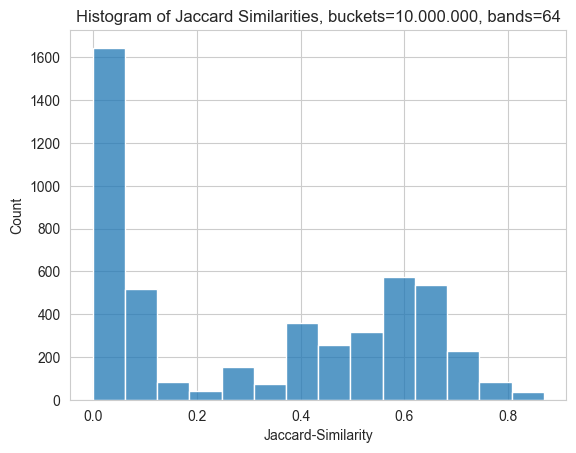

In [48]:
sns.histplot(candidate_pairs_df['Jaccard-Similarity'])
plt.title('Histogram of Jaccard Similarities, buckets=10.000.000, bands=64')
plt.show()